# Compound file processing - Part 2

- Read Plate, Well and compound metdata files
- Create Plate/Well/Compound metadata file consisting of
    - Plate info
    - Well Info
    - Compound info
- Join above file with Compound TPSA file

In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:98% !important; }</style>"))
%load_ext autoreload  
%autoreload 2
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [206]:
import os
import sys
import argparse
import csv
import json
import time
import types, copy, pprint
from datetime import datetime
import numpy as np
import pandas as pd
from scipy.sparse import csr_matrix
from utils import getTPSAFromRDKit, getSmilesFromRDKit
from rdkit import Chem
from rdkit.Chem import PandasTools 


pp = pprint.PrettyPrinter(indent=4)
np.set_printoptions(edgeitems=3, infstr='inf', linewidth=150, nanstr='nan')
pd.options.display.width = 132

os.environ["WANDB_NOTEBOOK_NAME"] = "Adashare_Train.ipynb"
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"

In [3]:
# time.strftime(' %x%X')
# datetime.now().strftime('%X.%f')
# time.strftime('%X %x %Z')
print(datetime.now().strftime('%D-%X.%f'))
time_fmt = '%Y-%M-%d %H:%m:%S.%f'
print(datetime.now().strftime(time_fmt))

01/24/24-13:44:42.725649
2024-44-24 13:01:42.725793


In [4]:
# from chembl_webresource_client.new_client import new_client
# from chembl_webresource_client.utils import utils
# import pubchempy as pcp

In [5]:
# import rdkit
# from rdkit.Chem import inchi
# from rdkit.Chem import INCHI_AVAILABLE
# from rdkit import Chem
# from rdkit.Chem.Draw import IPythonConsole
# from rdkit.Chem import Draw
# IPythonConsole.ipython_useSVG=True  #< set this to False if you want PNGs instead of SVGs
# import rdkit.Avalon.pyAvalonTools as pat
# import rdkit.Chem.MolStandardize as rdms
# from rdkit.Chem import ChemicalFeatures
# from rdkit import RDConfig
# from rdkit.Chem import AllChem
# from rdkit.Chem.Pharm2D import Generate
# from rdkit.Chem.Pharm2D import Gobbi_Pharm2D

# if INCHI_AVAILABLE:
#   from rdkit.Chem import InchiReadWriteError
#   from rdkit.Chem import MolToInchi, MolBlockToInchi, MolFromInchi, InchiToInchiKey, MolToInchiKey, MolFromMolFile, MolToMolFile
# else:
#     print('INCHI not available')

In [6]:
input_path ="./metadata/"
output_path ="./output_11102023/"
prefix = '' ### Target-2' , 'MOA'
prefix_lc = prefix.lower().replace('-', '_')
 
# compoundMetadataInputFile   = f"{input_path}JUMP-{prefix}_compound_library.csv"

compoundMetadataInputFile         = f"{input_path}{prefix_lc}compound.csv"
plateMetadataInputFile            = f"{input_path}{prefix_lc}plate_new.csv"
# wellMetadataInputFile             = f"{input_path}{prefix_lc}well_new.csv"
wellMetadataInputFile             = f"{input_path}{prefix_lc}well.csv.gz"

compoundMetadataCleanFile         = f"{output_path}{prefix_lc}compound_metadata_clean.csv"

compoundMetadataTPSAFile          = f"{output_path}{prefix_lc}compound_metadata_tpsa.csv"
compoundMetadataTPSACleanFile     = f"{output_path}{prefix_lc}compound_metadata_tpsa_clean.csv"
compoundTPSAFile                  = f"{output_path}{prefix_lc}compound_TPSA.csv"
compoundTPSACleanFile             = f"{output_path}{prefix_lc}compound_TPSA_clean.csv"

compoundPharmacophoreFile         = f"{output_path}{prefix_lc}compound_pharmacophores_sparse.pkl"
compoundPharmacophoreCleanFile    = f"{output_path}{prefix_lc}compound_pharmacophores_sparse_clean.pkl"
compoundPharmacophoreDenseFile    = f"{output_path}{prefix_lc}compound_pharmacophores_dense.npy"
compoundPharmacophoreDenseZipFile = f"{output_path}{prefix_lc}compound_pharmacophores_dense.npz"

CompoundExtendedMetadataFile      = f"{output_path}{prefix_lc}compound_extended_metadata.csv"
CompoundExtendedMetadata5SampleFile      = f"{output_path}{prefix_lc}compound_extended_metadata_5samples.csv"
CompoundExtendedMetadata2SampleFile      = f"{output_path}{prefix_lc}compound_extended_metadata_2samples.csv"

print(f" prefix                                   : {prefix} \n" )
print(f" compound Metadata Input File             : {compoundMetadataInputFile}")
print(f" plate Metadata Input File                : {plateMetadataInputFile}")
print(f" well Metadata Input File                 : {wellMetadataInputFile}")
print(f" ")
print(f" compound Metadata Output File            : {compoundMetadataCleanFile}\n")
print(f" ")
print(f" compound Metadata + TPSA File            : {compoundMetadataTPSAFile}")
print(f" compound Metadata + TPSA Cleaned File    : {compoundMetadataTPSACleanFile}\n")
print(f" ")
print(f" CompoundExtendedMetadataFile             : {CompoundExtendedMetadataFile }")
print(f" CompoundExtendedMetadataSampleFile       : {CompoundExtendedMetadata2SampleFile }")
print(f" ")
print(f" compound TPSA File                       : {compoundTPSAFile}")
print(f" compound TPSA Clean File                 : {compoundTPSACleanFile}\n")
# print(f" compound Pharmacophore Sparse File       : {compoundPharmacophoreFile}")
# print(f" compound Pharmacophore Sparse Clean File : {compoundPharmacophoreCleanFile}\n")
# print(f" compound Pharmacophore Dense File        : {compoundPharmacophoreDenseFile}")
# print(f" compound Pharmacophore Dense Zipped File : {compoundPharmacophoreDenseZipFile}")

 prefix                                   :  

 compound Metadata Input File             : ./metadata/compound.csv
 plate Metadata Input File                : ./metadata/plate_new.csv
 well Metadata Input File                 : ./metadata/well.csv.gz
 
 compound Metadata Output File            : ./output_11102023/compound_metadata_clean.csv

 
 compound Metadata + TPSA File            : ./output_11102023/compound_metadata_tpsa.csv
 compound Metadata + TPSA Cleaned File    : ./output_11102023/compound_metadata_tpsa_clean.csv

 
 CompoundExtendedMetadataFile             : ./output_11102023/compound_extended_metadata.csv
 CompoundExtendedMetadataSampleFile       : ./output_11102023/compound_extended_metadata_2samples.csv
 
 compound TPSA File                       : ./output_11102023/compound_TPSA.csv
 compound TPSA Clean File                 : ./output_11102023/compound_TPSA_clean.csv



# Read Metadata files

## compound_metadata_clean file

In [8]:
# df = pd.read_csv('JUMP-MOA_compound_metadata.tsv', delimiter='\t')
# df = pd.read_csv('JUMP-Target-1_compound_metadata.tsv', delimiter='\t')
# df = pd.read_csv(compoundMetadataOutputFile)
# df = pd.read_csv(compoundMetadataOutputFile_2)
# inputFile1 = compoundMetadataTPSAFile

inputFile1 = compoundMetadataTPSACleanFile
df_compounds = pd.read_csv(inputFile1)
print(f"input file 1  {inputFile1}")
# df_compounds.drop(columns=["_merge", "Unnamed: 0"], inplace=True)
df_compounds.info()
# df_compounds.head(2)
df_compounds.tail(10)

# df_compounds[df_compounds.Metadata_JCP2022 == "JCP2022_UNKNOWN"]

input file 1  ./output_11102023/compound_metadata_tpsa_clean.csv
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 116691 entries, 0 to 116690
Data columns (total 8 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Metadata_JCP2022   116691 non-null  object 
 1   Metadata_InChIKey  116691 non-null  object 
 2   Metadata_InChI     116691 non-null  object 
 3   smiles             116691 non-null  object 
 4   TPSA               116691 non-null  float64
 5   lnTPSA             116691 non-null  float64
 6   log10TPSA          116691 non-null  float64
 7   permiation         116691 non-null  int64  
dtypes: float64(3), int64(1), object(4)
memory usage: 7.1+ MB


,Metadata_JCP2022,Metadata_InChIKey,Metadata_InChI,smiles,TPSA,lnTPSA,log10TPSA,permiation
116681,JCP2022_116744,ZZYKBSGXGACMPA-UHFFFAOYSA-N,"InChI=1S/C24H28O3/c1-24(2,3)22(25)15-21(17-9-1...",COc1ccc(cc1)C(CC(=O)C(C)(C)C)C3CCc2ccccc2C3=O,43.37,3.769768,1.637189,0
116682,JCP2022_116745,ZZYXOZDOAUYJMM-UHFFFAOYSA-N,InChI=1S/C14H16N4O5/c1-22-11-4-3-9(7-12(11)23-...,COc2ccc(CCNC(=O)C1=NNC=C1[N+]([O-])=O)cc2OC,119.38,4.782312,2.076932,1
116683,JCP2022_116746,ZZZDEKSRJRMEHB-UHFFFAOYSA-N,InChI=1S/C13H8ClN3O2S/c14-9-4-2-1-3-8(9)11(18)...,OC(=NC2=CN=C1SC=CN1C2=O)c3ccccc3Cl,66.96,4.204095,1.825815,0
116684,JCP2022_116747,ZZZDOWYROHPYBD-UHFFFAOYSA-N,InChI=1S/C13H20N4O2/c1-15-11-10(12(18)16(2)13(...,CN2C(=O)C1CN(CNC=1N(C)C2=O)C3CCCC3,59.27,4.082103,1.772835,0
116685,JCP2022_116748,ZZZQXCUPAJFVBN-UHFFFAOYSA-N,InChI=1S/C17H16FN3/c1-10(2)15-9-16(21-17(19)20...,CC(C)C1=CC(=NC(=N)N1)c2ccc(F)c3ccccc23,52.53,3.961384,1.720407,0
116686,JCP2022_116749,ZZZRUAITSXLWBH-UHFFFAOYSA-N,InChI=1S/C23H27N3O7/c1-25(2)12-5-6-13(27)15-10...,CN(C)C3C(=O)C(C(=N)O)C(=O)C4(O)C(=O)C2C(=O)c1c...,159.30,5.070789,2.202216,1
116687,JCP2022_116750,ZZZTXDPKNAOZPM-UHFFFAOYSA-N,InChI=1S/C22H27N3O2/c1-14-18(22(27)24-15(2)23-...,Cc4nc(C)c(CCC(=O)N(C1CC1)C2CCCc3ccccc23)c(O)n4,66.32,4.194492,1.821645,0
116688,JCP2022_116751,ZZZUOLMMTJKOGE-UHFFFAOYSA-N,InChI=1S/C19H17N5O2/c1-23-9-6-13-7-10-24(19(26...,CN4C=CC3C=CN(CCN=C(O)c2cnc1ccccc1n2)C(=O)C=34,85.30,4.446174,1.930949,0
116689,JCP2022_116752,ZZZZIBSVRUABIA-UHFFFAOYSA-N,InChI=1S/C19H13F6N3O2S/c1-11-26-6-5-17(27-11)1...,Cc1nccc(n1)c2cccc(c2)NS(=O)(=O)c3cc(cc(c3)C(F)...,71.95,4.275971,1.857031,0
116690,JCP2022_116753,ZZZZVNLQWWXZTQ-UHFFFAOYSA-N,InChI=1S/C14H20N2O3/c1-18-13-5-3-2-4-12(13)14(...,COc1ccccc1C(O)=NCCN2CCOCC2,54.29,3.994340,1.734720,0


## Plate Metadata

In [9]:
inputFile3 = plateMetadataInputFile
df_plate = pd.read_csv(inputFile3)
print(f"Plate file:  {inputFile3}")

Plate file:  ./metadata/plate_new.csv


In [10]:
print(df_plate.info())
df_plate.head(2)
df_plate.tail(2)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2378 entries, 0 to 2377
Data columns (total 4 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Metadata_Source     2378 non-null   object
 1   Metadata_Batch      2378 non-null   object
 2   Metadata_Plate      2378 non-null   object
 3   Metadata_PlateType  2378 non-null   object
dtypes: object(4)
memory usage: 74.4+ KB
None


,Metadata_Source,Metadata_Batch,Metadata_Plate,Metadata_PlateType
0,source_1,Batch1_20221004,UL000109,COMPOUND_EMPTY
1,source_1,Batch1_20221004,UL001641,COMPOUND


,Metadata_Source,Metadata_Batch,Metadata_Plate,Metadata_PlateType
2376,source_9,20211103-Run16,GR00004420,COMPOUND
2377,source_9,20211103-Run16,GR00004421,COMPOUND


In [11]:
df_plate.Metadata_PlateType.value_counts()
df_plate.Metadata_Source.value_counts()
# df[df['Metadata_JCP2022'].isna()]

COMPOUND          1729
ORF                251
CRISPR             148
TARGET2            141
DMSO                77
COMPOUND_EMPTY      20
POSCON8              8
TARGET1              4
Name: Metadata_PlateType, dtype: int64

source_3     303
source_4     277
source_5     260
source_6     246
source_2     229
source_10    222
source_8     216
source_11    180
source_13    154
source_7     128
source_9     108
source_1      55
Name: Metadata_Source, dtype: int64

## Well/Compound Metadata

In [12]:
inputFile2 = wellMetadataInputFile
df_wells = pd.read_csv(inputFile2)
print(f"Well file: {inputFile2}")

Well file: ./metadata/well.csv.gz


In [13]:
print(df_wells.info())
df_wells.head(2)
df_wells.tail(2)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1096074 entries, 0 to 1096073
Data columns (total 4 columns):
 #   Column            Non-Null Count    Dtype 
---  ------            --------------    ----- 
 0   Metadata_Source   1096074 non-null  object
 1   Metadata_Plate    1096074 non-null  object
 2   Metadata_Well     1096074 non-null  object
 3   Metadata_JCP2022  1096074 non-null  object
dtypes: object(4)
memory usage: 33.4+ MB
None


,Metadata_Source,Metadata_Plate,Metadata_Well,Metadata_JCP2022
0,source_1,UL000081,A02,JCP2022_033924
1,source_1,UL000081,A03,JCP2022_085227


,Metadata_Source,Metadata_Plate,Metadata_Well,Metadata_JCP2022
1096072,source_9,GR00004421,Z47,JCP2022_033924
1096073,source_9,GR00004421,Z48,JCP2022_037716


In [14]:
df_compound_counts = df_wells['Metadata_JCP2022'].unique()
print(f" Number of unqiue compounds ::  {len(df_compound_counts)}")

 Number of unqiue compounds ::  138907


In [15]:
df_compound_counts = df_wells['Metadata_JCP2022'].value_counts() 
len(df_compound_counts)
print("Well counts by compound")
print("-----------------------")
df_compound_counts[:35]

138907

Well counts by compound
-----------------------


JCP2022_033924     138936
JCP2022_999999      37094
JCP2022_UNKNOWN     12574
JCP2022_050797       9732
JCP2022_037716       9571
JCP2022_012818       9544
JCP2022_025848       9513
JCP2022_046054       9508
JCP2022_064022       9346
JCP2022_085227       8923
JCP2022_035095       7983
JCP2022_800001       4724
JCP2022_800002       2754
JCP2022_915132       2026
JCP2022_033954       1594
JCP2022_915129        973
JCP2022_915128        973
JCP2022_915131        973
JCP2022_915130        973
JCP2022_900001        632
JCP2022_805264        569
JCP2022_033914        362
JCP2022_013856        361
JCP2022_001036        359
JCP2022_105442        356
JCP2022_080920        355
JCP2022_073628        354
JCP2022_056401        354
JCP2022_032771        354
JCP2022_004587        354
JCP2022_046462        354
JCP2022_060040        353
JCP2022_015955        349
JCP2022_102083        348
JCP2022_001890        344
Name: Metadata_JCP2022, dtype: int64

# Create Plate/Well/Compound  file

## Extract all plates where PlateType == `COMPOUND`

In [16]:
# df_compound_plates = df_plate[(df_plate.Metadata_PlateType == 'COMPOUND') & (df_plate.Metadata_Source=='source_3')]
df_cmp_plates = df_plate[(df_plate.Metadata_PlateType == 'COMPOUND') ]
df_cmp_plates.info()
df_cmp_plates.head(10)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1729 entries, 1 to 2377
Data columns (total 4 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Metadata_Source     1729 non-null   object
 1   Metadata_Batch      1729 non-null   object
 2   Metadata_Plate      1729 non-null   object
 3   Metadata_PlateType  1729 non-null   object
dtypes: object(4)
memory usage: 67.5+ KB


,Metadata_Source,Metadata_Batch,Metadata_Plate,Metadata_PlateType
1,source_1,Batch1_20221004,UL001641,COMPOUND
2,source_1,Batch1_20221004,UL001643,COMPOUND
3,source_1,Batch1_20221004,UL001645,COMPOUND
4,source_1,Batch1_20221004,UL001651,COMPOUND
5,source_1,Batch1_20221004,UL001653,COMPOUND
6,source_1,Batch1_20221004,UL001655,COMPOUND
9,source_1,Batch2_20221006,UL001647,COMPOUND
10,source_1,Batch2_20221006,UL001649,COMPOUND
11,source_1,Batch2_20221006,UL001671,COMPOUND
12,source_1,Batch2_20221006,UL001673,COMPOUND


In [17]:
df_cmp_plates.Metadata_Source.value_counts()
# df_compound_plates.Metadata_Batch.value_counts()

source_3     237
source_6     225
source_2     219
source_10    208
source_8     199
source_5     197
source_11    173
source_7     121
source_9      99
source_1      51
Name: Metadata_Source, dtype: int64

## Join Plates and Well-Compound information

In [18]:
df_cmp_plates_wells = pd.merge(df_cmp_plates, df_wells, how='left', on=['Metadata_Source','Metadata_Plate'], indicator = True)

In [19]:
df_cmp_plates_wells.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 832295 entries, 0 to 832294
Data columns (total 7 columns):
 #   Column              Non-Null Count   Dtype   
---  ------              --------------   -----   
 0   Metadata_Source     832295 non-null  object  
 1   Metadata_Batch      832295 non-null  object  
 2   Metadata_Plate      832295 non-null  object  
 3   Metadata_PlateType  832295 non-null  object  
 4   Metadata_Well       832295 non-null  object  
 5   Metadata_JCP2022    832295 non-null  object  
 6   _merge              832295 non-null  category
dtypes: category(1), object(6)
memory usage: 45.2+ MB


In [20]:
df_cmp_plates_wells.head(4)
df_cmp_plates_wells.tail(4)
df_cmp_plates_wells._merge.value_counts()
df_cmp_plates_wells.Metadata_Source.value_counts()

,Metadata_Source,Metadata_Batch,Metadata_Plate,Metadata_PlateType,Metadata_Well,Metadata_JCP2022,_merge
0,source_1,Batch1_20221004,UL001641,COMPOUND,A02,JCP2022_033924,both
1,source_1,Batch1_20221004,UL001641,COMPOUND,A03,JCP2022_085227,both
2,source_1,Batch1_20221004,UL001641,COMPOUND,A04,JCP2022_033924,both
3,source_1,Batch1_20221004,UL001641,COMPOUND,A05,JCP2022_036592,both


,Metadata_Source,Metadata_Batch,Metadata_Plate,Metadata_PlateType,Metadata_Well,Metadata_JCP2022,_merge
832291,source_9,20211103-Run16,GR00004421,COMPOUND,Z45,JCP2022_999999,both
832292,source_9,20211103-Run16,GR00004421,COMPOUND,Z46,JCP2022_999999,both
832293,source_9,20211103-Run16,GR00004421,COMPOUND,Z47,JCP2022_033924,both
832294,source_9,20211103-Run16,GR00004421,COMPOUND,Z48,JCP2022_037716,both


both          832295
left_only          0
right_only         0
Name: _merge, dtype: int64

source_9     152064
source_3      90929
source_6      86395
source_2      84032
source_10     79862
source_8      76401
source_5      75646
source_1      74843
source_11     65663
source_7      46460
Name: Metadata_Source, dtype: int64

In [28]:
# df_compound_counts = df_cmp_plates_wells['Metadata_JCP2022'].unique()
print(f" Number of unqiue compounds ::  {len(df_cmp_plates_wells['Metadata_JCP2022'].unique())}")
df_compound_counts[:35]

 Number of unqiue compounds ::  115733


JCP2022_033924     138936
JCP2022_999999      37094
JCP2022_UNKNOWN     12574
JCP2022_050797       9732
JCP2022_037716       9571
JCP2022_012818       9544
JCP2022_025848       9513
JCP2022_046054       9508
JCP2022_064022       9346
JCP2022_085227       8923
JCP2022_035095       7983
JCP2022_800001       4724
JCP2022_800002       2754
JCP2022_915132       2026
JCP2022_033954       1594
JCP2022_915129        973
JCP2022_915128        973
JCP2022_915131        973
JCP2022_915130        973
JCP2022_900001        632
JCP2022_805264        569
JCP2022_033914        362
JCP2022_013856        361
JCP2022_001036        359
JCP2022_105442        356
JCP2022_080920        355
JCP2022_073628        354
JCP2022_056401        354
JCP2022_032771        354
JCP2022_004587        354
JCP2022_046462        354
JCP2022_060040        353
JCP2022_015955        349
JCP2022_102083        348
JCP2022_001890        344
Name: Metadata_JCP2022, dtype: int64

## Drop rows with an invalid compound (`JCP2022_999999` or  `JCP2022_UNKNOWN`)

In [25]:
join_999999  = df_cmp_plates_wells[df_cmp_plates_wells.Metadata_JCP2022 == 'JCP2022_999999']
len(join_999999)
join_999999.head(3)
join_999999_indexes = join_999999.index
join_999999_indexes[:3]

print(f" Number of entires with compound = JCP2022_999999: {len(join_999999_indexes)}")

25724

,Metadata_Source,Metadata_Batch,Metadata_Plate,Metadata_PlateType,Metadata_Well,Metadata_JCP2022,_merge
74847,source_10,2021_05_31_U2OS_48_hr_run1,Dest210531-152149,COMPOUND,A05,JCP2022_999999,both
74851,source_10,2021_05_31_U2OS_48_hr_run1,Dest210531-152149,COMPOUND,A09,JCP2022_999999,both
74855,source_10,2021_05_31_U2OS_48_hr_run1,Dest210531-152149,COMPOUND,A13,JCP2022_999999,both


Int64Index([74847, 74851, 74855], dtype='int64')

 Number of entires with compound = JCP2022_999999: 25724


In [23]:
join_unknown = df_cmp_plates_wells[df_cmp_plates_wells.Metadata_JCP2022 == 'JCP2022_UNKNOWN']
len(join_unknown)
join_unknown.head(3)
join_unknown_indexes = join_unknown.index
join_unknown_indexes[:10]
print(f" Number of entires with compound = JCP2022_UNKNOWN: {len(join_unknown_indexes)}")

12574

,Metadata_Source,Metadata_Batch,Metadata_Plate,Metadata_PlateType,Metadata_Well,Metadata_JCP2022,_merge
172602,source_11,Batch2,EC000053,COMPOUND,C12,JCP2022_UNKNOWN,both
172603,source_11,Batch2,EC000053,COMPOUND,C13,JCP2022_UNKNOWN,both
172604,source_11,Batch2,EC000053,COMPOUND,C14,JCP2022_UNKNOWN,both


Int64Index([172602, 172603, 172604, 172605, 172606, 172607, 172608, 172609, 172610, 172611], dtype='int64')

12574

In [27]:
join_033924 = df_cmp_plates_wells[df_cmp_plates_wells.Metadata_JCP2022 == 'JCP2022_033924']
len(join_033924)
join_033924.head(3)
join_033924_indexes = join_033924.index
join_033924_indexes[:10]
print(f" Number of entires with compound = JCP2022_033924: {len(join_033924_indexes)}")

88583

,Metadata_Source,Metadata_Batch,Metadata_Plate,Metadata_PlateType,Metadata_Well,Metadata_JCP2022,_merge
0,source_1,Batch1_20221004,UL001641,COMPOUND,A02,JCP2022_033924,both
2,source_1,Batch1_20221004,UL001641,COMPOUND,A04,JCP2022_033924,both
43,source_1,Batch1_20221004,UL001641,COMPOUND,A45,JCP2022_033924,both


Int64Index([0, 2, 43, 45, 46, 48, 89, 91, 92, 94], dtype='int64')

 Number of entires with compound = JCP2022_033924: 88583


In [1]:
# df_cmp_plates_wells.groupby('Metadata_JCP2022').count()


In [239]:
all_invalid_indexes = join_999999_indexes.union(join_unknown_indexes)  ##.union(join_033924_indexes)
# joined_invalid_indexes
print(' indexes in join_999999: ', len(join_999999_indexes))
print(' indexes in join_unknown: ', len(join_unknown_indexes))
print(' indexes in join_033924: ', len(join_033924_indexes))
print(' common indexes: ',len(join_unknown_indexes  & join_999999_indexes & join_033924_indexes))
print(' indexes in union: ', len(all_invalid_indexes))


NameError: name 'join_999999_indexes' is not defined

In [32]:
print(25724 + 12574 + 88583)
print(705414 + 25724 + 12574 + 88583)
print(793997 + 25724 + 12574 )

126881
832295
832295


In [30]:
df_cmp_plates_wells.drop(all_invalid_indexes, inplace = True)
df_cmp_plates_wells.drop(columns=['_merge','Metadata_PlateType'],inplace = True)


In [31]:
df_cmp_plates_wells.info()
df_cmp_plates_wells.head(10)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 793997 entries, 0 to 832294
Data columns (total 5 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   Metadata_Source   793997 non-null  object
 1   Metadata_Batch    793997 non-null  object
 2   Metadata_Plate    793997 non-null  object
 3   Metadata_Well     793997 non-null  object
 4   Metadata_JCP2022  793997 non-null  object
dtypes: object(5)
memory usage: 36.3+ MB


,Metadata_Source,Metadata_Batch,Metadata_Plate,Metadata_Well,Metadata_JCP2022
0,source_1,Batch1_20221004,UL001641,A02,JCP2022_033924
1,source_1,Batch1_20221004,UL001641,A03,JCP2022_085227
2,source_1,Batch1_20221004,UL001641,A04,JCP2022_033924
3,source_1,Batch1_20221004,UL001641,A05,JCP2022_036592
4,source_1,Batch1_20221004,UL001641,A06,JCP2022_071885
5,source_1,Batch1_20221004,UL001641,A07,JCP2022_088861
6,source_1,Batch1_20221004,UL001641,A08,JCP2022_078645
7,source_1,Batch1_20221004,UL001641,A09,JCP2022_074163
8,source_1,Batch1_20221004,UL001641,A10,JCP2022_041689
9,source_1,Batch1_20221004,UL001641,A11,JCP2022_098761


# Create Extended Metadata / Coupund File 

- a file of Plate/Well/Compound/TPSA information

## Join selected Plate/Well Metadata with Compound/TPSA Data

In [33]:
try: 
    del joined_metadata
except Exception as e:
    print('Doesnt exist')

Doesnt exist


In [34]:
df_cmp_plates_wells.info()
print(f" Number of unqiue compounds ::  {len(df_cmp_plates_wells['Metadata_JCP2022'].unique())}")

<class 'pandas.core.frame.DataFrame'>
Int64Index: 793997 entries, 0 to 832294
Data columns (total 5 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   Metadata_Source   793997 non-null  object
 1   Metadata_Batch    793997 non-null  object
 2   Metadata_Plate    793997 non-null  object
 3   Metadata_Well     793997 non-null  object
 4   Metadata_JCP2022  793997 non-null  object
dtypes: object(5)
memory usage: 36.3+ MB
 Number of unqiue compounds ::  115731


In [35]:
df_compounds.info()
print(f" Number of unqiue compounds ::  {len(df_compounds['Metadata_JCP2022'].unique())}")
# df_compounds.head(2)
# df_compounds.drop(columns='Unnamed: 0',inplace = True)
# df_compounds.head(2)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 116691 entries, 0 to 116690
Data columns (total 8 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Metadata_JCP2022   116691 non-null  object 
 1   Metadata_InChIKey  116691 non-null  object 
 2   Metadata_InChI     116691 non-null  object 
 3   smiles             116691 non-null  object 
 4   TPSA               116691 non-null  float64
 5   lnTPSA             116691 non-null  float64
 6   log10TPSA          116691 non-null  float64
 7   permiation         116691 non-null  int64  
dtypes: float64(3), int64(1), object(4)
memory usage: 7.1+ MB
 Number of unqiue compounds ::  116691


In [36]:
joined_metadata = pd.merge(df_cmp_plates_wells, df_compounds, on="Metadata_JCP2022")

In [37]:
joined_metadata.info()
joined_metadata.head()
print(f" Number of unqiue compounds ::  {len(joined_metadata['Metadata_JCP2022'].unique())}")

<class 'pandas.core.frame.DataFrame'>
Int64Index: 793603 entries, 0 to 793602
Data columns (total 12 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Metadata_Source    793603 non-null  object 
 1   Metadata_Batch     793603 non-null  object 
 2   Metadata_Plate     793603 non-null  object 
 3   Metadata_Well      793603 non-null  object 
 4   Metadata_JCP2022   793603 non-null  object 
 5   Metadata_InChIKey  793603 non-null  object 
 6   Metadata_InChI     793603 non-null  object 
 7   smiles             793603 non-null  object 
 8   TPSA               793603 non-null  float64
 9   lnTPSA             793603 non-null  float64
 10  log10TPSA          793603 non-null  float64
 11  permiation         793603 non-null  int64  
dtypes: float64(3), int64(1), object(8)
memory usage: 78.7+ MB


,Metadata_Source,Metadata_Batch,Metadata_Plate,Metadata_Well,Metadata_JCP2022,Metadata_InChIKey,Metadata_InChI,smiles,TPSA,lnTPSA,log10TPSA,permiation
0,source_1,Batch1_20221004,UL001641,A02,JCP2022_033924,IAZDPXIOMUYVGZ-UHFFFAOYSA-N,InChI=1S/C2H6OS/c1-4(2)3/h1-2H3,CS(C)=O,17.07,2.837323,1.232234,0
1,source_1,Batch1_20221004,UL001641,A04,JCP2022_033924,IAZDPXIOMUYVGZ-UHFFFAOYSA-N,InChI=1S/C2H6OS/c1-4(2)3/h1-2H3,CS(C)=O,17.07,2.837323,1.232234,0
2,source_1,Batch1_20221004,UL001641,A45,JCP2022_033924,IAZDPXIOMUYVGZ-UHFFFAOYSA-N,InChI=1S/C2H6OS/c1-4(2)3/h1-2H3,CS(C)=O,17.07,2.837323,1.232234,0
3,source_1,Batch1_20221004,UL001641,A47,JCP2022_033924,IAZDPXIOMUYVGZ-UHFFFAOYSA-N,InChI=1S/C2H6OS/c1-4(2)3/h1-2H3,CS(C)=O,17.07,2.837323,1.232234,0
4,source_1,Batch1_20221004,UL001641,AA02,JCP2022_033924,IAZDPXIOMUYVGZ-UHFFFAOYSA-N,InChI=1S/C2H6OS/c1-4(2)3/h1-2H3,CS(C)=O,17.07,2.837323,1.232234,0


 Number of unqiue compounds ::  115671


In [ ]:
# joined_metadata.reset_index(drop = False)
df_1 = joined_metadata.set_index('Metadata_JCP2022', drop = False)
df_1.info()
df_1.head(3)
df_1 = df_1.reset_index(drop = True)
df_1.info()
df_1.head(3)

## Plot Compound Well counts

In [55]:
df_compound_counts.info()
df_compound_counts.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 115671 entries, 0 to 115670
Data columns (total 2 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   Metadata_JCP2022  115671 non-null  object
 1   Counts            115671 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 1.8+ MB


,Metadata_JCP2022,Counts
0,JCP2022_033924,88583
1,JCP2022_037716,8138
2,JCP2022_064022,8130
3,JCP2022_050797,8127
4,JCP2022_025848,8127
5,JCP2022_046054,8122
6,JCP2022_012818,8111
7,JCP2022_085227,7707
8,JCP2022_035095,6550
9,JCP2022_033954,1594


In [53]:
 df_compound_counts.Counts.min(), df_compound_counts.Counts.max(), df_compound_counts.Counts.mean() , df_compound_counts.Counts.median()

(1, 88583, 6.860864002213174, 5.0)

In [62]:
df_compound_counts.head(10)

,Metadata_JCP2022,Counts
0,JCP2022_033924,88583
1,JCP2022_037716,8138
2,JCP2022_064022,8130
3,JCP2022_050797,8127
4,JCP2022_025848,8127
5,JCP2022_046054,8122
6,JCP2022_012818,8111
7,JCP2022_085227,7707
8,JCP2022_035095,6550
9,JCP2022_033954,1594


In [114]:
df_well_use_counts = df_compound_counts.Counts.value_counts()
df_well_use_counts.info()
print('# of Wells used     Compound Count')
df_well_use_counts[:20]
df_well_use_counts.sort_index(inplace=True)
df_well_use_counts[:10]

<class 'pandas.core.series.Series'>
Int64Index: 51 entries, 4 to 1
Series name: Counts
Non-Null Count  Dtype
--------------  -----
51 non-null     int64
dtypes: int64(1)
memory usage: 816.0 bytes
# of Wells used     Compound Count


4     41322
5     32115
7     18419
8      9503
6      4913
3      2873
10     2327
9      1995
12      730
15      289
11      261
17      178
2       156
14      136
16       78
20       66
13       61
19       34
22       32
21       30
Name: Counts, dtype: int64

1         1
2       156
3      2873
4     41322
5     32115
6      4913
7     18419
8      9503
9      1995
10     2327
Name: Counts, dtype: int64

In [112]:
len(df_well_use_counts.index), len(df_well_use_counts.values)
df_well_use_counts.sort_values()[:20]
 

(51, 51)

1        1
8130     1
8122     1
8111     1
7707     1
6550     1
1594     1
58       1
49       1
47       1
43       1
41       1
39       1
37       1
8138     1
88583    1
8127     2
35       2
33       2
31       2
Name: Counts, dtype: int64

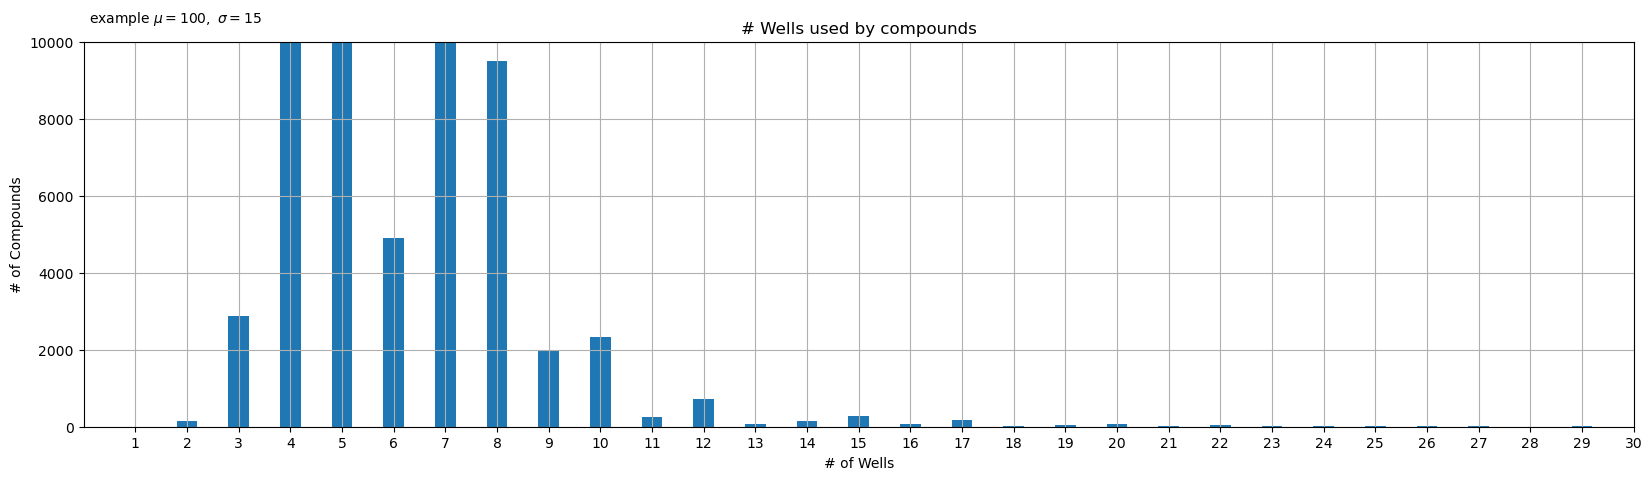

In [116]:
# the histogram of the data
_= plt.figure(figsize=(20, 5))
_= plt.bar(df_well_use_counts.index, df_well_use_counts.values, tick_label=df_well_use_counts.index, width = 0.4 ) 
##  , facecolor='g', alpha=0.75, rwidth=1.0, orientation='horizontal')
_= plt.xlabel('# of Wells')
_= plt.ylabel('# of Compounds')
_= plt.title('# Wells used by compounds')
_= plt.text(0.1, 10500, r'example $\mu=100,\ \sigma=15$')
_= plt.xlim(0, 30)
_= plt.ylim(0, 10000)
_= plt.grid(True)
plt.show()

In [83]:
# import matplotlib.pyplot as plt
# # the histogram of the data
# plt.figure(figsize=(20, 5))
# # _ = plt.bar(np.log(df_well_use_counts.index), df_well_use_counts.values, tick_label = labels, width = 0.1,log = False) ##  , facecolor='g', alpha=0.75, rwidth=1.0, orientation='horizontal')
# _ = plt.bar(df_well_use_counts.index, df_well_use_counts.values, tick_label = labels, range=width = 0.1 ) ##  , facecolor='g', alpha=0.75, rwidth=1.0, orientation='horizontal')
# plt.xlabel('# of Wells');
# plt.ylabel('# of Compounds')
# plt.title('# Wells used by compounds')
# # plt.text(60, .025, r'$\mu=100,\ \sigma=15$')
# # plt.xlim(0, 60)
# # plt.ylim(0, 1000)
# plt.grid(True)
# plt.show()

### Histogram

In [120]:
# df_compound_counts
# df_well_use_counts?

## Check if any rows have a TPSA of 0.0 or Nan

In [142]:
joined_md_zero = joined_metadata_2[joined_metadata_2['TPSA'] == 0.0]
len(joined_md_zero)
# joined_md_zero

joined_md_inv = joined_metadata[joined_metadata['TPSA'].isna()]
len(joined_md_inv)
# joined_md_inv

joined_md_inv = joined_metadata[joined_metadata['TPSA'] == 0.0]
len(joined_md_inv)
# joined_md_inv

0

0

0

## Sort by Source, Batch, and Plate  

In [146]:
joined_metadata.sort_values(by=['Metadata_Source','Metadata_Batch','Metadata_Plate'], inplace=True)
len(joined_metadata)
joined_metadata.head(5)

793603

,Metadata_Source,Metadata_Batch,Metadata_Plate,Metadata_Well,Metadata_JCP2022,Metadata_InChIKey,Metadata_InChI,smiles,TPSA,lnTPSA,log10TPSA,permiation
0,source_1,Batch1_20221004,UL001641,A02,JCP2022_033924,IAZDPXIOMUYVGZ-UHFFFAOYSA-N,InChI=1S/C2H6OS/c1-4(2)3/h1-2H3,CS(C)=O,17.07,2.837323,1.232234,0
1,source_1,Batch1_20221004,UL001641,A04,JCP2022_033924,IAZDPXIOMUYVGZ-UHFFFAOYSA-N,InChI=1S/C2H6OS/c1-4(2)3/h1-2H3,CS(C)=O,17.07,2.837323,1.232234,0
2,source_1,Batch1_20221004,UL001641,A45,JCP2022_033924,IAZDPXIOMUYVGZ-UHFFFAOYSA-N,InChI=1S/C2H6OS/c1-4(2)3/h1-2H3,CS(C)=O,17.07,2.837323,1.232234,0
3,source_1,Batch1_20221004,UL001641,A47,JCP2022_033924,IAZDPXIOMUYVGZ-UHFFFAOYSA-N,InChI=1S/C2H6OS/c1-4(2)3/h1-2H3,CS(C)=O,17.07,2.837323,1.232234,0
4,source_1,Batch1_20221004,UL001641,AA02,JCP2022_033924,IAZDPXIOMUYVGZ-UHFFFAOYSA-N,InChI=1S/C2H6OS/c1-4(2)3/h1-2H3,CS(C)=O,17.07,2.837323,1.232234,0


## Write resulting file  
`./output/compound_extended_metadata.csv`

In [147]:
print(CompoundExtendedMetadataFile)

./output_11102023/compound_extended_metadata.csv


In [148]:
joined_metadata.to_csv(CompoundExtendedMetadataFile, index = False)

# Create Extended Metadata Sample file 

In [155]:

try: 
    # del join_033924, join_033924_indexes,  join_999999, join_999999_indexes, join_unknown, join_unknown_indexes
    del joined_md_inv, joined_md_zero, joined_metadata_2, joined_metadata
except Exception as e:
    print(' does not exist -- delete skipped') 

 does not exist -- delete skipped


In [156]:
print(f" compound Extended Metadata File  : {CompoundExtendedMetadataFile}\n")

 compound Extended Metadata File  : ./output_11102023/compound_extended_metadata.csv



In [162]:
joined_metadata = pd.read_csv(CompoundExtendedMetadataFile)

/tmp/ipykernel_1810636/1524408378.py:1: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  joined_metadata = pd.read_csv(CompoundExtendedMetadataFile)


In [163]:

# df.drop(columns=["_merge", "Unnamed: 0"], inplace = True)
joined_metadata.shape
joined_metadata.info()
joined_metadata.head(2)
joined_metadata.tail(2)

(793603, 12)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 793603 entries, 0 to 793602
Data columns (total 12 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Metadata_Source    793603 non-null  object 
 1   Metadata_Batch     793603 non-null  object 
 2   Metadata_Plate     793603 non-null  object 
 3   Metadata_Well      793603 non-null  object 
 4   Metadata_JCP2022   793603 non-null  object 
 5   Metadata_InChIKey  793603 non-null  object 
 6   Metadata_InChI     793603 non-null  object 
 7   smiles             793603 non-null  object 
 8   TPSA               793603 non-null  float64
 9   lnTPSA             793603 non-null  float64
 10  log10TPSA          793603 non-null  float64
 11  permiation         793603 non-null  int64  
dtypes: float64(3), int64(1), object(8)
memory usage: 72.7+ MB


,Metadata_Source,Metadata_Batch,Metadata_Plate,Metadata_Well,Metadata_JCP2022,Metadata_InChIKey,Metadata_InChI,smiles,TPSA,lnTPSA,log10TPSA,permiation
0,source_1,Batch1_20221004,UL001641,A02,JCP2022_033924,IAZDPXIOMUYVGZ-UHFFFAOYSA-N,InChI=1S/C2H6OS/c1-4(2)3/h1-2H3,CS(C)=O,17.07,2.837323,1.232234,0
1,source_1,Batch1_20221004,UL001641,A04,JCP2022_033924,IAZDPXIOMUYVGZ-UHFFFAOYSA-N,InChI=1S/C2H6OS/c1-4(2)3/h1-2H3,CS(C)=O,17.07,2.837323,1.232234,0


,Metadata_Source,Metadata_Batch,Metadata_Plate,Metadata_Well,Metadata_JCP2022,Metadata_InChIKey,Metadata_InChI,smiles,TPSA,lnTPSA,log10TPSA,permiation
793601,source_9,20211103-Run16,GR00004421,Q05,JCP2022_016626,DKZPFMKULLAVMW-UHFFFAOYSA-N,InChI=1S/C17H22N2O3S/c1-3-22-16-6-4-15-13-17(7...,CCOc2ccc1cc(ccc1c2)S(=O)(=O)N3CCN(C)CC3,49.85,3.909018,1.697665,0
793602,source_9,20211103-Run16,GR00004421,Z12,JCP2022_083151,SGXOORQZRWPAML-UHFFFAOYSA-N,InChI=1S/C18H20N4O5/c1-11-8-14(21-27-11)19-15(...,COc1ccccc1CC3(C)N=C(O)N(CC(=O)N=C2C=C(C)ON2)C3=O,120.49,4.791567,2.080951,1


In [164]:
df_test = joined_metadata[joined_metadata['Metadata_InChI'].isna()]
len(df_test)
df_test = joined_metadata[joined_metadata['smiles'].isna()]
len(df_test)
df_test = joined_metadata[joined_metadata['TPSA'].isna()]
len(df_test)
# df[df['pharmacophore_base64'].isna()]
# len(df)

0

0

0

In [160]:
df_cemd.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 793603 entries, 0 to 793602
Data columns (total 12 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Metadata_Source    793603 non-null  object 
 1   Metadata_Batch     793603 non-null  object 
 2   Metadata_Plate     793603 non-null  object 
 3   Metadata_Well      793603 non-null  object 
 4   Metadata_JCP2022   793603 non-null  object 
 5   Metadata_InChIKey  793603 non-null  object 
 6   Metadata_InChI     793603 non-null  object 
 7   smiles             793603 non-null  object 
 8   TPSA               793603 non-null  float64
 9   lnTPSA             793603 non-null  float64
 10  log10TPSA          793603 non-null  float64
 11  permiation         793603 non-null  int64  
dtypes: float64(3), int64(1), object(8)
memory usage: 72.7+ MB


## Drop compounds applied to less than 3 wells 

### Counts of compounds

In [167]:
df_compound_counts = joined_metadata['Metadata_JCP2022'].value_counts().to_frame(name = 'Counts')
df_compound_counts.reset_index(drop = False, names = 'Metadata_JCP2022', inplace = True)
df_compound_counts.info()
df_compound_counts.head(3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 115671 entries, 0 to 115670
Data columns (total 2 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   Metadata_JCP2022  115671 non-null  object
 1   Counts            115671 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 1.8+ MB


,Metadata_JCP2022,Counts
0,JCP2022_033924,88583
1,JCP2022_037716,8138
2,JCP2022_064022,8130


In [168]:
df_eligble_compounds  = df_compound_counts[(df_compound_counts.Counts >= 3) ]
df_ineligble_compounds  = df_compound_counts[(df_compound_counts.Counts < 3) ]
# df_eligble_compounds  = df_compound_counts[(df_compound_counts.Counts > 3) & (df_compound_counts.Counts < 1000)]

In [176]:
df_eligble_compounds.info()
df_eligble_compounds.head(5)
df_compound_counts.shape
df_eligble_compounds.shape
df_ineligble_compounds.shape
joined_metadata.shape


<class 'pandas.core.frame.DataFrame'>
Int64Index: 115514 entries, 0 to 115513
Data columns (total 2 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   Metadata_JCP2022  115514 non-null  object
 1   Counts            115514 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 2.6+ MB


,Metadata_JCP2022,Counts
0,JCP2022_033924,88583
1,JCP2022_037716,8138
2,JCP2022_064022,8130
3,JCP2022_050797,8127
4,JCP2022_025848,8127


(115671, 2)

(115514, 2)

(157, 2)

(793603, 12)

In [177]:
joined_metadata_2 = pd.merge(df_eligble_compounds, joined_metadata, how='left', on=['Metadata_JCP2022'], indicator = True)
# joined_metadata_2 = df_eligble_compounds.join(joined_metadata, how='left', on='Metadata_JCP2022')
joined_metadata_2.drop(columns=['Counts','_merge'],inplace = True)

In [178]:
joined_metadata_2.shape
# joined_metadata_2.info()
joined_metadata_2.head()
print(f" Number of unqiue compounds ::  {len(joined_metadata_2['Metadata_JCP2022'].unique())}")
print()
joined_metadata_2['Metadata_JCP2022'].value_counts() 

(793290, 12)

,Metadata_JCP2022,Metadata_Source,Metadata_Batch,Metadata_Plate,Metadata_Well,Metadata_InChIKey,Metadata_InChI,smiles,TPSA,lnTPSA,log10TPSA,permiation
0,JCP2022_033924,source_1,Batch1_20221004,UL001641,A02,IAZDPXIOMUYVGZ-UHFFFAOYSA-N,InChI=1S/C2H6OS/c1-4(2)3/h1-2H3,CS(C)=O,17.07,2.837323,1.232234,0
1,JCP2022_033924,source_1,Batch1_20221004,UL001641,A04,IAZDPXIOMUYVGZ-UHFFFAOYSA-N,InChI=1S/C2H6OS/c1-4(2)3/h1-2H3,CS(C)=O,17.07,2.837323,1.232234,0
2,JCP2022_033924,source_1,Batch1_20221004,UL001641,A45,IAZDPXIOMUYVGZ-UHFFFAOYSA-N,InChI=1S/C2H6OS/c1-4(2)3/h1-2H3,CS(C)=O,17.07,2.837323,1.232234,0
3,JCP2022_033924,source_1,Batch1_20221004,UL001641,A47,IAZDPXIOMUYVGZ-UHFFFAOYSA-N,InChI=1S/C2H6OS/c1-4(2)3/h1-2H3,CS(C)=O,17.07,2.837323,1.232234,0
4,JCP2022_033924,source_1,Batch1_20221004,UL001641,AA02,IAZDPXIOMUYVGZ-UHFFFAOYSA-N,InChI=1S/C2H6OS/c1-4(2)3/h1-2H3,CS(C)=O,17.07,2.837323,1.232234,0


 Number of unqiue compounds ::  115514



JCP2022_033924    88583
JCP2022_037716     8138
JCP2022_064022     8130
JCP2022_050797     8127
JCP2022_025848     8127
                  ...  
JCP2022_079404        3
JCP2022_045870        3
JCP2022_049817        3
JCP2022_035068        3
JCP2022_099232        3
Name: Metadata_JCP2022, Length: 115514, dtype: int64

In [179]:
# joined_metadata_2.sort_values(by=['Metadata_Source','Metadata_Batch','Metadata_Plate'], inplace=True)
len(joined_metadata_2)
joined_metadata_2.head(5)

793290

,Metadata_JCP2022,Metadata_Source,Metadata_Batch,Metadata_Plate,Metadata_Well,Metadata_InChIKey,Metadata_InChI,smiles,TPSA,lnTPSA,log10TPSA,permiation
0,JCP2022_033924,source_1,Batch1_20221004,UL001641,A02,IAZDPXIOMUYVGZ-UHFFFAOYSA-N,InChI=1S/C2H6OS/c1-4(2)3/h1-2H3,CS(C)=O,17.07,2.837323,1.232234,0
1,JCP2022_033924,source_1,Batch1_20221004,UL001641,A04,IAZDPXIOMUYVGZ-UHFFFAOYSA-N,InChI=1S/C2H6OS/c1-4(2)3/h1-2H3,CS(C)=O,17.07,2.837323,1.232234,0
2,JCP2022_033924,source_1,Batch1_20221004,UL001641,A45,IAZDPXIOMUYVGZ-UHFFFAOYSA-N,InChI=1S/C2H6OS/c1-4(2)3/h1-2H3,CS(C)=O,17.07,2.837323,1.232234,0
3,JCP2022_033924,source_1,Batch1_20221004,UL001641,A47,IAZDPXIOMUYVGZ-UHFFFAOYSA-N,InChI=1S/C2H6OS/c1-4(2)3/h1-2H3,CS(C)=O,17.07,2.837323,1.232234,0
4,JCP2022_033924,source_1,Batch1_20221004,UL001641,AA02,IAZDPXIOMUYVGZ-UHFFFAOYSA-N,InChI=1S/C2H6OS/c1-4(2)3/h1-2H3,CS(C)=O,17.07,2.837323,1.232234,0


## Sample Extended Metadata file



   Sample Compounds from `df_pwc`- 2 per source

- Do we want to just sample by Compound, or by Source as well?

In [186]:
### Sample Plates from `df_compound_plates`- 2 per source

# df_compound_plates.head()

#  sample = (
#     df_compound_plates.groupby(["Metadata_Source", "Metadata_Batch"])
#     .sample(2, random_state=42, replace = True)   ## sample 2 per Metadata_Source
# )
# sample
# # sample.Metadata_Batch.sum()
115514 * 2
115514 * 3

231028

346542

In [180]:
try:
    del sample
except Exception as e:
    print('Not deleted')

In [181]:
SAMPLES = 2

In [184]:
 sample = (
    joined_metadata_2.groupby(["Metadata_JCP2022"])
    .sample(SAMPLES, random_state=42, replace = False)   ## sample 2 per Metadata_Source
)
sample
# sample.Metadata_Batch.sum()


,Metadata_JCP2022,Metadata_Source,Metadata_Batch,Metadata_Plate,Metadata_Well,Metadata_InChIKey,Metadata_InChI,smiles,TPSA,lnTPSA,log10TPSA,permiation
763156,JCP2022_000001,source_10,2021_06_22_U2OS_48_hr_run8,Dest210622-144945,C07,AAAHWCWPZPSPIW-UHFFFAOYSA-N,InChI=1S/C25H31N5O2/c1-4-23-26-14-16-30(23)24-...,CCC1=NC=CN1c2cccc(n2)C3CCCN3C(=O)c4ccc(cc4)OCC...,63.49,4.150882,1.802705,0
763158,JCP2022_000001,source_6,p210928CPU2OS48hw384exp030JUMP,110000296383,B15,AAAHWCWPZPSPIW-UHFFFAOYSA-N,InChI=1S/C25H31N5O2/c1-4-23-26-14-16-30(23)24-...,CCC1=NC=CN1c2cccc(n2)C3CCCN3C(=O)c4ccc(cc4)OCC...,63.49,4.150882,1.802705,0
627800,JCP2022_000002,source_10,2021_08_03_U2OS_48_hr_run12,Dest210726-163143,D21,AAAJHRMBUHXWLD-UHFFFAOYSA-N,InChI=1S/C11H13ClN2O/c12-10-4-2-9(3-5-10)8-14-...,OC1=NCCCN1Cc2ccc(Cl)cc2,35.83,3.578786,1.554247,0
627802,JCP2022_000002,source_8,J1,A1170405,B22,AAAJHRMBUHXWLD-UHFFFAOYSA-N,InChI=1S/C11H13ClN2O/c12-10-4-2-9(3-5-10)8-14-...,OC1=NCCCN1Cc2ccc(Cl)cc2,35.83,3.578786,1.554247,0
656662,JCP2022_000004,source_6,p210928CPU2OS48hw384exp030JUMP,110000296367,I21,AAANUZMCJQUYNX-UHFFFAOYSA-N,InChI=1S/C13H22N4O2S/c1-2-7-16-13(5-6-15-16)20...,CCCN1N=CC=C1S(=O)(=O)N2CC3CNCC2CC3,67.23,4.208120,1.827563,0
...,...,...,...,...,...,...,...,...,...,...,...,...
483059,JCP2022_116751,source_10,2021_05_31_U2OS_48_hr_run1,Dest210531-152634,C04,ZZZUOLMMTJKOGE-UHFFFAOYSA-N,InChI=1S/C19H17N5O2/c1-23-9-6-13-7-10-24(19(26...,CN4C=CC3C=CN(CCN=C(O)c2cnc1ccccc1n2)C(=O)C=34,85.30,4.446174,1.930949,0
709800,JCP2022_116752,source_2,20210614_Batch_1,1053600759,B15,ZZZZIBSVRUABIA-UHFFFAOYSA-N,InChI=1S/C19H13F6N3O2S/c1-11-26-6-5-17(27-11)1...,Cc1nccc(n1)c2cccc(c2)NS(=O)(=O)c3cc(cc(c3)C(F)...,71.95,4.275971,1.857031,0
709802,JCP2022_116752,source_8,J2,A1170487,I09,ZZZZIBSVRUABIA-UHFFFAOYSA-N,InChI=1S/C19H13F6N3O2S/c1-11-26-6-5-17(27-11)1...,Cc1nccc(n1)c2cccc(c2)NS(=O)(=O)c3cc(cc(c3)C(F)...,71.95,4.275971,1.857031,0
389569,JCP2022_116753,source_9,20210918-Run12,GR00004385,O42,ZZZZVNLQWWXZTQ-UHFFFAOYSA-N,InChI=1S/C14H20N2O3/c1-18-13-5-3-2-4-12(13)14(...,COc1ccccc1C(O)=NCCN2CCOCC2,54.29,3.994340,1.734720,0


In [189]:
sample.Metadata_Source.value_counts()

source_9     33524
source_3     27884
source_1     27555
source_10    26362
source_6     26190
source_8     24833
source_2     24490
source_5     16361
source_11    14813
source_7      9016
Name: Metadata_Source, dtype: int64

In [190]:
# df_pwc[df_pwc.Metadata_Source == 'source_1'].Metadata_Source.value_counts()
# df_pwc[df_pwc.Metadata_Source == 'source_1'].Metadata_Batch.value_counts()
# df_pwc[df_pwc.Metadata_Source == 'source_1'].Metadata_Plate.value_counts()
# df_pwc[df_pwc.Metadata_Source == 'source_1'].Metadata_JCP2022.value_counts()

### Write sample file to disk

In [191]:
# print(f" compound Extended Metadata Sample File  : {CompoundExtendedMetadata5SampleFile}\n")
print(f" compound Extended Metadata Sample File  : {CompoundExtendedMetadata2SampleFile}\n")

 compound Extended Metadata Sample File  : ./output_11102023/compound_extended_metadata_2samples.csv



In [192]:
# sample.to_csv(CompoundExtendedMetadataSampleFile, index = False)
sample.to_csv(CompoundExtendedMetadata2SampleFile, index = False)

# Explore Compounds w/ high count on the Extended Metadata file

In [193]:
# df_compounds.info()
# df_compounds.head()
df_compounds_indexed = df_compounds.copy()
df_compounds_indexed.info()
df_compounds_indexed.set_index("Metadata_JCP2022", drop = False, inplace = True)
df_compounds_indexed.info()
df_compounds_indexed.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 116691 entries, 0 to 116690
Data columns (total 8 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Metadata_JCP2022   116691 non-null  object 
 1   Metadata_InChIKey  116691 non-null  object 
 2   Metadata_InChI     116691 non-null  object 
 3   smiles             116691 non-null  object 
 4   TPSA               116691 non-null  float64
 5   lnTPSA             116691 non-null  float64
 6   log10TPSA          116691 non-null  float64
 7   permiation         116691 non-null  int64  
dtypes: float64(3), int64(1), object(4)
memory usage: 7.1+ MB
<class 'pandas.core.frame.DataFrame'>
Index: 116691 entries, JCP2022_000001 to JCP2022_116753
Data columns (total 8 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Metadata_JCP2022   116691 non-null  object 
 1   Metadata_InChIKey  116691 non-null  object 
 2   Metadata_In

,Metadata_JCP2022,Metadata_InChIKey,Metadata_InChI,smiles,TPSA,lnTPSA,log10TPSA,permiation
Metadata_JCP2022,,,,,,,,
JCP2022_000001,JCP2022_000001,AAAHWCWPZPSPIW-UHFFFAOYSA-N,InChI=1S/C25H31N5O2/c1-4-23-26-14-16-30(23)24-...,CCC1=NC=CN1c2cccc(n2)C3CCCN3C(=O)c4ccc(cc4)OCC...,63.49,4.150882,1.802705,0
JCP2022_000002,JCP2022_000002,AAAJHRMBUHXWLD-UHFFFAOYSA-N,InChI=1S/C11H13ClN2O/c12-10-4-2-9(3-5-10)8-14-...,OC1=NCCCN1Cc2ccc(Cl)cc2,35.83,3.578786,1.554247,0
JCP2022_000003,JCP2022_000003,AAALVYBICLMAMA-UHFFFAOYSA-N,InChI=1S/C20H15N3O2/c24-19-15-11-17(21-13-7-3-...,OC2=NC(=O)c3cc(Nc1ccccc1)c(cc23)Nc4ccccc4,73.72,4.300274,1.867585,0
JCP2022_000004,JCP2022_000004,AAANUZMCJQUYNX-UHFFFAOYSA-N,InChI=1S/C13H22N4O2S/c1-2-7-16-13(5-6-15-16)20...,CCCN1N=CC=C1S(=O)(=O)N2CC3CNCC2CC3,67.23,4.208120,1.827563,0
JCP2022_000005,JCP2022_000005,AAAQFGUYHFJNHI-UHFFFAOYSA-N,InChI=1S/C22H22ClN5O2/c1-4-24-20(29)12-18-22-2...,CCN=C(O)CC3N=C(c1ccc(Cl)cc1)c2cc(ccc2N4C(C)=NN...,84.89,4.441356,1.928857,0


In [194]:
compound_counts = joined_metadata['Metadata_JCP2022'].value_counts()

In [202]:
compound_counts.info()
len(compound_counts)
compound_counts[:30]
# df_pwc['Metadata_JCP2022'].unique().shape[0]

# del joined_metadata_indexed
# df_compounds_indexed
 
counts_gt_60 = compound_counts[compound_counts>60]
counts_gt_60

<class 'pandas.core.series.Series'>
Index: 115671 entries, JCP2022_033924 to JCP2022_090832
Series name: Metadata_JCP2022
Non-Null Count   Dtype
--------------   -----
115671 non-null  int64
dtypes: int64(1)
memory usage: 1.8+ MB


115671

JCP2022_033924    88583
JCP2022_037716     8138
JCP2022_064022     8130
JCP2022_050797     8127
JCP2022_025848     8127
JCP2022_046054     8122
JCP2022_012818     8111
JCP2022_085227     7707
JCP2022_035095     6550
JCP2022_033954     1594
JCP2022_101934       58
JCP2022_109350       49
JCP2022_018628       47
JCP2022_050997       43
JCP2022_072565       41
JCP2022_029611       39
JCP2022_029868       37
JCP2022_067216       35
JCP2022_061774       35
JCP2022_019441       34
JCP2022_062326       34
JCP2022_072343       34
JCP2022_059004       34
JCP2022_019585       33
JCP2022_095595       33
JCP2022_003104       32
JCP2022_083372       32
JCP2022_028032       32
JCP2022_006452       32
JCP2022_025420       31
Name: Metadata_JCP2022, dtype: int64

JCP2022_033924    88583
JCP2022_037716     8138
JCP2022_064022     8130
JCP2022_050797     8127
JCP2022_025848     8127
JCP2022_046054     8122
JCP2022_012818     8111
JCP2022_085227     7707
JCP2022_035095     6550
JCP2022_033954     1594
Name: Metadata_JCP2022, dtype: int64

In [203]:
counts_gt_60 = df_compounds_indexed.loc[compound_counts[compound_counts>60].index]
counts_gt_60

,Metadata_JCP2022,Metadata_InChIKey,Metadata_InChI,smiles,TPSA,lnTPSA,log10TPSA,permiation
JCP2022_033924,JCP2022_033924,IAZDPXIOMUYVGZ-UHFFFAOYSA-N,InChI=1S/C2H6OS/c1-4(2)3/h1-2H3,CS(C)=O,17.07,2.837323,1.232234,0
JCP2022_037716,JCP2022_037716,IVUGFMLRJOCGAS-UHFFFAOYSA-N,InChI=1S/C28H21N7OS/c1-17-15-24(37-16-17)25-20...,CC1=CSC(=C1)c5nnc(Nc2ccc(cc2)Oc3ncccc3C4C=CNC(...,112.46,4.722598,2.050998,1
JCP2022_064022,JCP2022_064022,OINGHOPGNMYCAB-UHFFFAOYSA-N,InChI=1S/C23H25ClF3N5O/c1-13(2)28-23(33)31-8-7...,CC(C)N=C(O)N1CCC(C1)N=C3Nc2cc(F)ccc2N(CC(F)F)c...,63.46,4.150410,1.802500,0
JCP2022_050797,JCP2022_050797,LOUPRKONTZGTKE-UHFFFAOYSA-N,InChI=1S/C20H24N2O2/c1-3-13-12-22-9-7-14(13)10...,C=CC1CN2CCC1CC2C(O)c3ccnc4ccc(cc34)OC,45.59,3.819688,1.658870,0
JCP2022_025848,JCP2022_025848,GJFCONYVAUNLKB-UHFFFAOYSA-N,InChI=1S/C22H29FO5/c1-12-8-16-15-5-4-13-9-14(2...,CC4CC3C2CC=C1CC(=O)C=CC1(C)C2(F)C(O)CC3(C)C4(O...,94.83,4.552086,1.976946,0
JCP2022_046054,JCP2022_046054,KPBNHDGDUADAGP-UHFFFAOYSA-N,InChI=1S/C24H29N3O2/c28-23(12-11-21-8-6-15-25-...,OC(C=Cc1cccnc1)=NCCCCC2CCN(CC2)C(=O)c3ccccc3,65.79,4.186468,1.818160,0
JCP2022_012818,JCP2022_012818,CQKBSRPVZZLCJE-UHFFFAOYSA-N,InChI=1S/C23H17Cl2N5O4/c1-34-23-27-11-14-8-16(...,COc4ncc3cc(C(=O)Nc1cc(ccc1Cl)C(O)=NCc2cccc(Cl)...,129.82,4.866149,2.113342,1
JCP2022_085227,JCP2022_085227,SRVFFFJZQVENJC-UHFFFAOYSA-N,InChI=1S/C17H30N2O5/c1-6-23-17(22)14-13(24-14)...,CCOC(=O)C1OC1C(O)=NC(CC(C)C)C(O)=NCCC(C)C,104.01,4.644487,2.017075,1
JCP2022_035095,JCP2022_035095,IHLVSLOZUHKNMQ-UHFFFAOYSA-N,InChI=1S/C26H27N5O2/c1-2-9-27-22(4-1)26-25(24-...,C(CN1CCOCC1)Oc2ccc3c(c2)nccc3C5=C4CCCN4N=C5c6c...,65.30,4.178992,1.814913,0
JCP2022_033954,JCP2022_033954,IBCXZJCWDGCXQT-UHFFFAOYSA-N,InChI=1S/C17H12N4/c1-2-6-15-13(5-1)12(8-10-19-...,C1NN=C(C=1c2ccnc3ccccc23)c4ccccn4,54.46,3.997466,1.736078,0


In [204]:
# counts_gt_60.Metadata_InChIKey

## Add Molecule to dataframe

In [208]:
PandasTools.AddMoleculeColumnToFrame(counts_gt_60,smilesCol='smiles')

,Metadata_JCP2022,Metadata_InChIKey,Metadata_InChI,smiles,TPSA,lnTPSA,log10TPSA,permiation,ROMol
JCP2022_033924,JCP2022_033924,IAZDPXIOMUYVGZ-UHFFFAOYSA-N,InChI=1S/C2H6OS/c1-4(2)3/h1-2H3,CS(C)=O,17.07,2.837323,1.232234,0,
JCP2022_037716,JCP2022_037716,IVUGFMLRJOCGAS-UHFFFAOYSA-N,InChI=1S/C28H21N7OS/c1-17-15-24(37-16-17)25-20...,CC1=CSC(=C1)c5nnc(Nc2ccc(cc2)Oc3ncccc3C4C=CNC(...,112.46,4.722598,2.050998,1,
JCP2022_064022,JCP2022_064022,OINGHOPGNMYCAB-UHFFFAOYSA-N,InChI=1S/C23H25ClF3N5O/c1-13(2)28-23(33)31-8-7...,CC(C)N=C(O)N1CCC(C1)N=C3Nc2cc(F)ccc2N(CC(F)F)c...,63.46,4.150410,1.802500,0,
JCP2022_050797,JCP2022_050797,LOUPRKONTZGTKE-UHFFFAOYSA-N,InChI=1S/C20H24N2O2/c1-3-13-12-22-9-7-14(13)10...,C=CC1CN2CCC1CC2C(O)c3ccnc4ccc(cc34)OC,45.59,3.819688,1.658870,0,
JCP2022_025848,JCP2022_025848,GJFCONYVAUNLKB-UHFFFAOYSA-N,InChI=1S/C22H29FO5/c1-12-8-16-15-5-4-13-9-14(2...,CC4CC3C2CC=C1CC(=O)C=CC1(C)C2(F)C(O)CC3(C)C4(O...,94.83,4.552086,1.976946,0,
JCP2022_046054,JCP2022_046054,KPBNHDGDUADAGP-UHFFFAOYSA-N,InChI=1S/C24H29N3O2/c28-23(12-11-21-8-6-15-25-...,OC(C=Cc1cccnc1)=NCCCCC2CCN(CC2)C(=O)c3ccccc3,65.79,4.186468,1.818160,0,
JCP2022_012818,JCP2022_012818,CQKBSRPVZZLCJE-UHFFFAOYSA-N,InChI=1S/C23H17Cl2N5O4/c1-34-23-27-11-14-8-16(...,COc4ncc3cc(C(=O)Nc1cc(ccc1Cl)C(O)=NCc2cccc(Cl)...,129.82,4.866149,2.113342,1,
JCP2022_085227,JCP2022_085227,SRVFFFJZQVENJC-UHFFFAOYSA-N,InChI=1S/C17H30N2O5/c1-6-23-17(22)14-13(24-14)...,CCOC(=O)C1OC1C(O)=NC(CC(C)C)C(O)=NCCC(C)C,104.01,4.644487,2.017075,1,
JCP2022_035095,JCP2022_035095,IHLVSLOZUHKNMQ-UHFFFAOYSA-N,InChI=1S/C26H27N5O2/c1-2-9-27-22(4-1)26-25(24-...,C(CN1CCOCC1)Oc2ccc3c(c2)nccc3C5=C4CCCN4N=C5c6c...,65.30,4.178992,1.814913,0,
JCP2022_033954,JCP2022_033954,IBCXZJCWDGCXQT-UHFFFAOYSA-N,InChI=1S/C17H12N4/c1-2-6-15-13(5-1)12(8-10-19-...,C1NN=C(C=1c2ccnc3ccccc23)c4ccccn4,54.46,3.997466,1.736078,0,

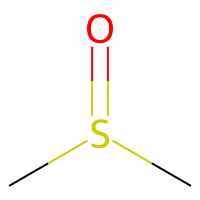
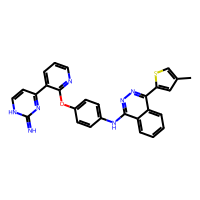
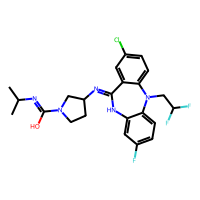
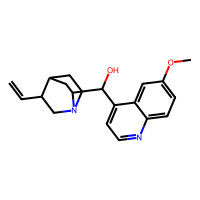
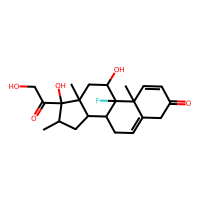
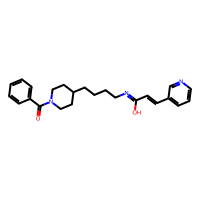
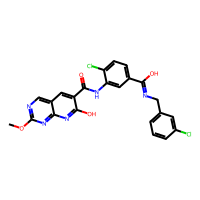
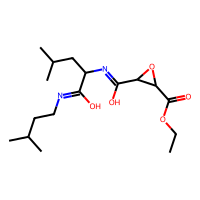
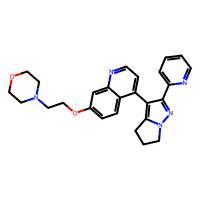
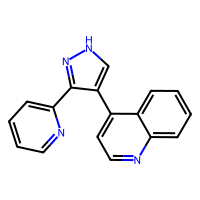

In [209]:
counts_gt_60

,Unnamed: 0,Metadata_JCP2022,Metadata_InChIKey,Metadata_InChI,smiles,TPSA,lnTPSA,log10TPSA,ROMol
JCP2022_033924,33922,JCP2022_033924,IAZDPXIOMUYVGZ-UHFFFAOYSA-N,InChI=1S/C2H6OS/c1-4(2)3/h1-2H3,CS(C)=O,17.07,2.837323,1.232234,
JCP2022_037716,37714,JCP2022_037716,IVUGFMLRJOCGAS-UHFFFAOYSA-N,InChI=1S/C28H21N7OS/c1-17-15-24(37-16-17)25-20...,CC1=CSC(=C1)c5nnc(Nc2ccc(cc2)Oc3ncccc3C4C=CNC(...,112.46,4.722598,2.050998,
JCP2022_064022,64020,JCP2022_064022,OINGHOPGNMYCAB-UHFFFAOYSA-N,InChI=1S/C23H25ClF3N5O/c1-13(2)28-23(33)31-8-7...,CC(C)N=C(O)N1CCC(C1)N=C3Nc2cc(F)ccc2N(CC(F)F)c...,63.46,4.150410,1.802500,
JCP2022_050797,50795,JCP2022_050797,LOUPRKONTZGTKE-UHFFFAOYSA-N,InChI=1S/C20H24N2O2/c1-3-13-12-22-9-7-14(13)10...,C=CC1CN2CCC1CC2C(O)c3ccnc4ccc(cc34)OC,45.59,3.819688,1.658870,
JCP2022_025848,25847,JCP2022_025848,GJFCONYVAUNLKB-UHFFFAOYSA-N,InChI=1S/C22H29FO5/c1-12-8-16-15-5-4-13-9-14(2...,CC4CC3C2CC=C1CC(=O)C=CC1(C)C2(F)C(O)CC3(C)C4(O...,94.83,4.552086,1.976946,
JCP2022_046054,46052,JCP2022_046054,KPBNHDGDUADAGP-UHFFFAOYSA-N,InChI=1S/C24H29N3O2/c28-23(12-11-21-8-6-15-25-...,OC(C=Cc1cccnc1)=NCCCCC2CCN(CC2)C(=O)c3ccccc3,65.79,4.186468,1.818160,
JCP2022_012818,12817,JCP2022_012818,CQKBSRPVZZLCJE-UHFFFAOYSA-N,InChI=1S/C23H17Cl2N5O4/c1-34-23-27-11-14-8-16(...,COc4ncc3cc(C(=O)Nc1cc(ccc1Cl)C(O)=NCc2cccc(Cl)...,129.82,4.866149,2.113342,
JCP2022_085227,85225,JCP2022_085227,SRVFFFJZQVENJC-UHFFFAOYSA-N,InChI=1S/C17H30N2O5/c1-6-23-17(22)14-13(24-14)...,CCOC(=O)C1OC1C(O)=NC(CC(C)C)C(O)=NCCC(C)C,104.01,4.644487,2.017075,
JCP2022_035095,35093,JCP2022_035095,IHLVSLOZUHKNMQ-UHFFFAOYSA-N,InChI=1S/C26H27N5O2/c1-2-9-27-22(4-1)26-25(24-...,C(CN1CCOCC1)Oc2ccc3c(c2)nccc3C5=C4CCCN4N=C5c6c...,65.30,4.178992,1.814913,
JCP2022_033954,33952,JCP2022_033954,IBCXZJCWDGCXQT-UHFFFAOYSA-N,InChI=1S/C17H12N4/c1-2-6-15-13(5-1)12(8-10-19-...,C1NN=C(C=1c2ccnc3ccccc23)c4ccccn4,54.46,3.997466,1.736078,

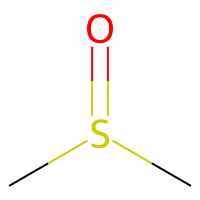
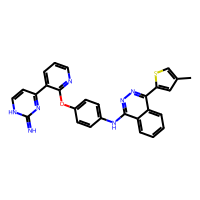
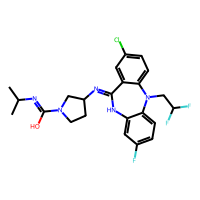
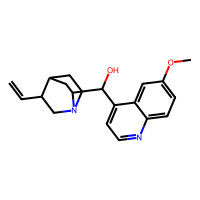
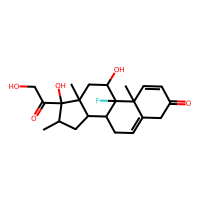
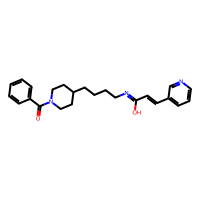
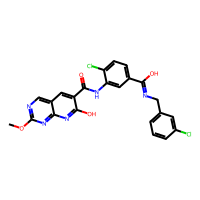
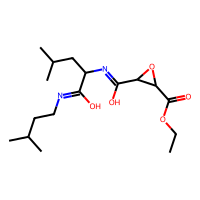
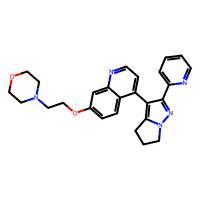
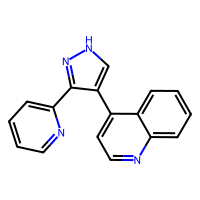

In [84]:
hi_counts

|A|B|
|---- |---- |
|CS(C)=O|tbd||
CC1=CSC(=C1)c5nnc(Nc2ccc(cc2)Oc3ncccc3C4C=CNC(=N)N=4)c6ccccc5|tbd|6|
CC(C)N=C(O)N1CCC(C1)N=C3Nc2cc(F)ccc2N(CC(F)F)c4ccc(Cl)cc|tbd|3|4
C=CC1CN2CCC1CC2C(O)c3ccnc4ccc(cc34|tbd|)|OC
CC4CC3C2CC=C1CC(=O)C=CC1(C)C2(F)C(O)CC3(C)C4(O)C(=|tbd|O|)CO
OC(C=Cc1cccnc1)=NCCCCC2CCN(CC2)C(=O)c3c|tbd|c|ccc3
COc4ncc3cc(C(=O)Nc1cc(ccc1Cl)C(O)=NCc2cccc(Cl)c2)c(O|tbd|)|nc3n4
CCOC(=O)C1OC1C(O)=NC(CC(C)C)C(O)=N|tbd|C|CC(C)C
C(CN1CCOCC1)Oc2ccc3c(c2)nccc3C5=C4CCCN4N=C5|tbd|c|6ccccn6
C1NN=C(C=1c2ccnc3ccccc23|tbd|)c4ccccn4

In [229]:
# for idx, val in compound_counts[compound_counts>60].items():
#     print(idx, '    ', df_compounds_indexed.loc[idx].smiles)
for row in counts_gt_60.itertuples():
    print(row.Index, '    ', row.smiles )

JCP2022_033924      CS(C)=O
JCP2022_037716      CC1=CSC(=C1)c5nnc(Nc2ccc(cc2)Oc3ncccc3C4C=CNC(=N)N=4)c6ccccc56
JCP2022_064022      CC(C)N=C(O)N1CCC(C1)N=C3Nc2cc(F)ccc2N(CC(F)F)c4ccc(Cl)cc34
JCP2022_050797      C=CC1CN2CCC1CC2C(O)c3ccnc4ccc(cc34)OC
JCP2022_025848      CC4CC3C2CC=C1CC(=O)C=CC1(C)C2(F)C(O)CC3(C)C4(O)C(=O)CO
JCP2022_046054      OC(C=Cc1cccnc1)=NCCCCC2CCN(CC2)C(=O)c3ccccc3
JCP2022_012818      COc4ncc3cc(C(=O)Nc1cc(ccc1Cl)C(O)=NCc2cccc(Cl)c2)c(O)nc3n4
JCP2022_085227      CCOC(=O)C1OC1C(O)=NC(CC(C)C)C(O)=NCCC(C)C
JCP2022_035095      C(CN1CCOCC1)Oc2ccc3c(c2)nccc3C5=C4CCCN4N=C5c6ccccn6
JCP2022_033954      C1NN=C(C=1c2ccnc3ccccc23)c4ccccn4


In [241]:
joined_metadata_2.info()
# joined_metadata_2.loc['JCP2022_033924'] 
joined_metadata_2[joined_metadata_2.Metadata_JCP2022 == 'JCP2022_033924'] 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 793603 entries, 0 to 793602
Data columns (total 12 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Metadata_Source    793603 non-null  object 
 1   Metadata_Batch     793603 non-null  object 
 2   Metadata_Plate     793603 non-null  object 
 3   Metadata_Well      793603 non-null  object 
 4   Metadata_JCP2022   793603 non-null  object 
 5   Metadata_InChIKey  793603 non-null  object 
 6   Metadata_InChI     793603 non-null  object 
 7   smiles             793603 non-null  object 
 8   TPSA               793603 non-null  float64
 9   lnTPSA             793603 non-null  float64
 10  log10TPSA          793603 non-null  float64
 11  permiation         793603 non-null  int64  
dtypes: float64(3), int64(1), object(8)
memory usage: 72.7+ MB


,Metadata_JCP2022,Metadata_Source,Metadata_Batch,Metadata_Plate,Metadata_Well,Metadata_InChIKey,Metadata_InChI,smiles,TPSA,lnTPSA,log10TPSA,permiation
0,JCP2022_033924,source_1,Batch1_20221004,UL001641,A02,IAZDPXIOMUYVGZ-UHFFFAOYSA-N,InChI=1S/C2H6OS/c1-4(2)3/h1-2H3,CS(C)=O,17.07,2.837323,1.232234,0
1,JCP2022_033924,source_1,Batch1_20221004,UL001641,A04,IAZDPXIOMUYVGZ-UHFFFAOYSA-N,InChI=1S/C2H6OS/c1-4(2)3/h1-2H3,CS(C)=O,17.07,2.837323,1.232234,0
2,JCP2022_033924,source_1,Batch1_20221004,UL001641,A45,IAZDPXIOMUYVGZ-UHFFFAOYSA-N,InChI=1S/C2H6OS/c1-4(2)3/h1-2H3,CS(C)=O,17.07,2.837323,1.232234,0
3,JCP2022_033924,source_1,Batch1_20221004,UL001641,A47,IAZDPXIOMUYVGZ-UHFFFAOYSA-N,InChI=1S/C2H6OS/c1-4(2)3/h1-2H3,CS(C)=O,17.07,2.837323,1.232234,0
4,JCP2022_033924,source_1,Batch1_20221004,UL001641,AA02,IAZDPXIOMUYVGZ-UHFFFAOYSA-N,InChI=1S/C2H6OS/c1-4(2)3/h1-2H3,CS(C)=O,17.07,2.837323,1.232234,0
...,...,...,...,...,...,...,...,...,...,...,...,...
88578,JCP2022_033924,source_9,20211103-Run16,GR00004421,Y47,IAZDPXIOMUYVGZ-UHFFFAOYSA-N,InChI=1S/C2H6OS/c1-4(2)3/h1-2H3,CS(C)=O,17.07,2.837323,1.232234,0
88579,JCP2022_033924,source_9,20211103-Run16,GR00004421,Z02,IAZDPXIOMUYVGZ-UHFFFAOYSA-N,InChI=1S/C2H6OS/c1-4(2)3/h1-2H3,CS(C)=O,17.07,2.837323,1.232234,0
88580,JCP2022_033924,source_9,20211103-Run16,GR00004421,Z23,IAZDPXIOMUYVGZ-UHFFFAOYSA-N,InChI=1S/C2H6OS/c1-4(2)3/h1-2H3,CS(C)=O,17.07,2.837323,1.232234,0
88581,JCP2022_033924,source_9,20211103-Run16,GR00004421,Z26,IAZDPXIOMUYVGZ-UHFFFAOYSA-N,InChI=1S/C2H6OS/c1-4(2)3/h1-2H3,CS(C)=O,17.07,2.837323,1.232234,0


In [238]:
# del sampleb

In [247]:
# .groupby(by = ['Metadata_Source', 'Metadata_Plate']) 
grouped_metadata = joined_metadata.groupby(by = ['Metadata_Source', 'Metadata_Plate'])

In [293]:
len(grouped_metadata)
cur_key = ''
cur_ttl = 0 
for ctr, (keys, group_data) in enumerate(grouped_metadata):
    if cur_key != keys[0]:
        print(f"       Total for plates {cur_key} : {cur_ttl}")
        cur_key = keys[0]
        cur_ttl = 0
    # print(f"{ctr:5d}     {keys[0]}   {keys[1]}   {group_data.shape[0]}") 
    cur_ttl += 1
    
    # group_data.info()
    # group_data.memory_usage(deep=True)
    # if ctr > 500:
    #     break
print(f"       Total for plates {cur_key} : {cur_ttl}")
    

1731

       Total for plates  : 0
       Total for plates source_1 : 51
       Total for plates source_10 : 208
       Total for plates source_11 : 173
       Total for plates source_2 : 219
       Total for plates source_3 : 237
       Total for plates source_5 : 197
       Total for plates source_6 : 227
       Total for plates source_7 : 121
       Total for plates source_8 : 199
       Total for plates source_9 : 99


In [ ]:
JCP2022_033924      CS(C)=O
JCP2022_037716      CC1=CSC(=C1)c5nnc(Nc2ccc(cc2)Oc3ncccc3C4C=CNC(=N)N=4)c6ccccc56
JCP2022_064022      CC(C)N=C(O)N1CCC(C1)N=C3Nc2cc(F)ccc2N(CC(F)F)c4ccc(Cl)cc34
JCP2022_050797      C=CC1CN2CCC1CC2C(O)c3ccnc4ccc(cc34)OC
JCP2022_025848      CC4CC3C2CC=C1CC(=O)C=CC1(C)C2(F)C(O)CC3(C)C4(O)C(=O)CO
JCP2022_046054      OC(C=Cc1cccnc1)=NCCCCC2CCN(CC2)C(=O)c3ccccc3
JCP2022_012818      COc4ncc3cc(C(=O)Nc1cc(ccc1Cl)C(O)=NCc2cccc(Cl)c2)c(O)nc3n4
JCP2022_085227      CCOC(=O)C1OC1C(O)=NC(CC(C)C)C(O)=NCCC(C)C
JCP2022_035095      C(CN1CCOCC1)Oc2ccc3c(c2)nccc3C5=C4CCCN4N=C5c6ccccn6
JCP2022_033954      C1NN=C(C=1c2ccnc3ccccc23)c4ccccn4

In [375]:
CC = "JCP2022_033924"
# CC = "JCP2022_037716"
# CC = "JCP2022_064022"
# CC = "JCP2022_050797"
# CC = "JCP2022_025848"
# CC = "JCP2022_046054"
# CC = "JCP2022_012818"
# CC = "JCP2022_085227"
# CC = "JCP2022_035095"
# CC = "JCP2022_033954"
dmso_metadata = joined_metadata[joined_metadata.Metadata_JCP2022 == CC]
dmso_metadata.shape 

grouped_dmso = dmso_metadata.groupby(by = ['Metadata_Source', 'Metadata_Plate'])

print(CC)
cur_key = ''
cur_plate_ttl = 0 
cur_well_ttl = 0 
well_ttl = 0
plate_ttl = 0
ttls = {} 
for ctr, (keys, group_data) in enumerate(grouped_dmso):
    if cur_key != keys[0]:
        if cur_key != '' :
            print(f"       Total for plates from {cur_key:10s} :    {cur_plate_ttl:4d}  total wells: {cur_well_ttl:5d} ")
            ttls[int(cur_key.split('_')[-1])] = (cur_plate_ttl, cur_well_ttl)
        cur_key = keys[0]
        cur_plate_ttl = 0
        cur_well_ttl = 0
    # print(f"{ctr:5d}     {keys[0]}   {keys[1]}   {group_data.shape[0]}") 
    cur_plate_ttl += 1
    plate_ttl +=1
    cur_well_ttl  += group_data.shape[0]
    well_ttl+= group_data.shape[0]
    # group_data.info()
    # group_data.memory_usage(deep=True)
    # if ctr > 500:
    #     break

print(f"       Total for plates from {cur_key:10s} :    {cur_plate_ttl:4d}  total wells: {cur_well_ttl:5d} ")

ttls[int(cur_key.split('_')[-1])] = (cur_plate_ttl, cur_well_ttl)
print(f'\n\n {CC} \n')
for i in range(1,12): 
    a = ttls.get(i, (1, 0))
    print(f" source {i:2d}    {a[0]:5d}   {a[1]:5d}   {a[1]/a[0]:>10.1f}")

print(f"\n plates : {plate_ttl}    wells: {well_ttl}")

(88583, 12)

JCP2022_033924
       Total for plates from source_1   :      51  total wells:  9217 
       Total for plates from source_10  :     205  total wells:  6560 
       Total for plates from source_11  :     173  total wells:  7587 
       Total for plates from source_2   :     219  total wells: 10877 
       Total for plates from source_3   :     237  total wells:  7574 
       Total for plates from source_5   :     197  total wells:  6304 
       Total for plates from source_6   :     225  total wells: 12832 
       Total for plates from source_7   :     121  total wells:  7184 
       Total for plates from source_8   :     199  total wells:  7776 
       Total for plates from source_9   :      99  total wells: 12672 


 JCP2022_033924 

 source  1       51    9217        180.7
 source  2      219   10877         49.7
 source  3      237    7574         32.0
 source  4        1       0          0.0
 source  5      197    6304         32.0
 source  6      225   12832         57.0
 source  

#### Histogram

In [110]:
# import matplotlib.pyplot as plt
# the histogram of the data
# plt.figure(figsize=(9, 5))
# n, bins, patches = plt.hist(df_compound_counts[10:].values, range(1,60), density= False) ##  , facecolor='g', alpha=0.75, rwidth=1.0, orientation='horizontal')
# n, bins, patches = plt.hist(df_well_use_counts, range(1,60), density= False) ##  , facecolor='g', alpha=0.75, rwidth=1.0, orientation='horizontal')

# print('n', n[:10])
# print('bins: ', bins[:10])
# plt.xlabel('Count')
# plt.ylabel('# of Wells')
# plt.title('Histogram')
# plt.text(60, .025, r'$\mu=100,\ \sigma=15$')
# plt.xlim(0, 60)
# plt.ylim(0, 10000)
# plt.grid(True)
# plt.show()